In [751]:
import os
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.io import loadmat
from tqdm import tqdm_notebook as tqdm

In [734]:
# handle data
csv_files = os.listdir('./dow30_dfs/')
djia_df = pd.DataFrame()
for csv_file in csv_files:
    file_names = csv_file.split('.')
    if file_names[-1] != 'csv':
        continue
    company_name = file_names[0]
    df = pd.read_csv('./dow30_dfs/{}'.format(csv_file))
    rate_df = (df[-1000:-495]['Close'].astype('float').pct_change() + 1)[1:]
    djia_df[company_name] = pd.Series(rate_df.values)
djia_df.to_csv('djia_20131217_20151217.csv', index=False)

In [735]:
# load data
djia_df = pd.read_csv('djia_20131217_20151217.csv')
djia_arr = djia_df.values

In [676]:
# load data
data = loadmat('./OLPS-master/Data/djia.mat')
data = np.array(data['data'])

In [736]:
data.shape

(507, 30)

In [690]:
djia_arr.shape

(504, 30)

In [658]:
# w, x are numpy array, shape: (m, )
def f(w, x):
    return - np.log(np.dot(w, x))
    
def grad(w, x):
    return - x / np.dot(w, x)

# reference https://arxiv.org/pdf/1101.6081.pdf
def proj_simplex(y):
    n = y.shape[0]
    x = cp.Variable(n)
    objective = cp.Minimize(cp.sum_squares(x - y))
    constraints = [x >= 0, cp.sum(x) == 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return x.value

# projection operation needed in online newton method
def proj_netwon(A, y):
    n = A.shape[0]
    x = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(x - y, A))
    constraints = [x >= 0, cp.sum(x) == 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return x.value

In [687]:
def best_hindsight(data):
    n, m = data.shape
    f_values = []
    w_opts = []
    for i in tqdm(range(n)):
        w = cp.Variable(m)
        objective = cp.Maximize(cp.sum(cp.log(data[:i + 1, ] @ w)))
        constraints = [cp.sum(w) == 1, w >= 0]
        prob = cp.Problem(objective, constraints)
        prob.solve(solver='SCS')
        w_opts.append(w.value)
        f_values.append(prob.value)
    return w_opts, f_values

In [660]:
# online gradient descent
def online_gradient_descent(data, eta):
    n, m = data.shape
    w_i = np.ones(m) / m
    f_values = []
    for i in tqdm(range(n)):
        x_i = data[i, :]
        f_i = f(w_i, x_i)
        f_values.append(f_i)
        # updata w_i
        grad_i = grad(w_i, x_i)
        w_i = proj_simplex(w_i - eta * grad_i)
    return f_values

In [661]:
# normalized exponentiated gradient
def normalized_EG(data, eta):
    n, m = data.shape
    w_i = np.ones(m) / m
    f_values = []
    for i in tqdm(range(n)):
        x_i = data[i, :]
        f_i = f(w_i, x_i)
        f_values.append(f_i)
        # update w_i
        grad_i = grad(w_i, x_i)
        w_i = w_i * np.exp(-eta * grad_i)
        w_i = w_i / np.sum(w_i)
    return f_values

In [662]:
# online newton step
def online_newton(data, eta, epsilon):
    n, m = data.shape
    w_i = np.ones(m) / m
    f_values = []
    A_i_inv = (1 / epsilon) * np.eye(m)
    A_i = epsilon * np.eye(m)
    for i in tqdm(range(n)):
        x_i = data[i, :]
        f_i = f(w_i, x_i)
        f_values.append(f_i)
        # update w_i
        grad_i = grad(w_i, x_i)
        hess_i = np.outer(grad_i, grad_i)
        A_i += hess_i
        A_i_inv -= A_i_inv.dot(hess_i).dot(A_i_inv) / (1 + grad_i.dot(A_i_inv).dot(grad_i))
        w_i = proj_netwon(A_i, w_i - eta * A_i_inv.dot(grad_i))
    return f_values

In [663]:
def online_newton2(data, eta, beta, delta):
    n, m = data.shape
    w_i = np.ones(m) / m
    f_values = []
    A_i_inv = np.eye(m)
    A_i = np.eye(m)
    cum_grad = np.zeros(m)
    cum_hess = np.zeros((m, m))
    for i in tqdm(range(n)):
        x_i = data[i, :]
        f_i = f(w_i, x_i)
        f_values.append(f_i)
        # update w
        grad_i = grad(w_i, x_i)
        hess_i = np.outer(grad_i, grad_i)
        cum_grad += grad_i
        cum_hess += hess_i
        A_i += hess_i
        A_i_inv -= A_i_inv.dot(hess_i).dot(A_i_inv) / (1 + grad_i.dot(A_i_inv).dot(grad_i))
        b_i = (1 + 1/beta) * cum_grad
        w_i = proj_netwon(A_i, delta * A_i_inv.dot(b_i))
        w_i = (1 - eta) * w_i + (eta / m) * np.ones(m) 
    return f_values

In [756]:
f_values_ons = online_newton2(data=djia_arr, eta=0, beta=0.125, delta = 1)
f_values_ons = np.cumsum(-np.array(f_values_ons))
f_values_ons = np.exp(f_values_ons)

A Jupyter Widget

In [768]:
f_values_eg = normalized_EG(data=djia_arr, eta=0.5)
f_values_eg = np.cumsum(-np.array(f_values_eg))
f_values_eg = np.exp(f_values_eg)

A Jupyter Widget

In [767]:
f_values_ogd = online_gradient_descent(data=djia_arr, eta=0.5)
f_values_ogd = np.cumsum(-np.array(f_values_ogd))
f_values_ogd = np.exp(f_values_ogd)

A Jupyter Widget

In [755]:
_, f_values_best = best_hindsight(data=djia_arr)
f_values_best = np.exp(f_values_best)

A Jupyter Widget

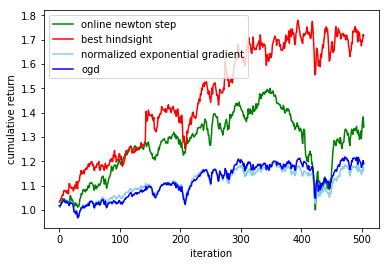

In [779]:
plt.plot(f_values_ons, color='green', label='online newton step')
plt.plot(f_values_best, color='red', label='best hindsight')
plt.plot(f_values_eg,  color='skyblue', label='normalized exponential gradient')
plt.plot(f_values_ogd, color='blue', label='ogd')
# plt.plot(np.cumprod(np.sum(djia_arr, axis=1) / 30), color='gray', label='market change')

plt.legend() # 显示图例

plt.xlabel('iteration')
plt.ylabel('cumulative return')
plt.show()